In [5]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [33]:
# 绘制模型表现图
def performance(y_true , predict , color = "g" , ann = True):
    acc = accuracy_score(y_true , predict[:] > 0.5)
    auc = roc_auc_score(y_true , predict[:])
    fpr , tpr , thr = roc_curve(y_true , predict[:])
    plt.figure()
    plt.plot(fpr , tpr )

# 读取数据

In [12]:
df_train = pd.read_csv("training.tsv",sep='\t',header=0)
df_validation = pd.read_csv("validation.tsv",sep='\t',header=0)
# print(df_validation.head(50))
train_X = df_train['review']
train_Y = df_train['sentiment']
validate_X = df_validation['review']
validate_Y = df_validation['sentiment']
print(validate_X)

0       JUDAAI was a bold film by Raj Kanwar at it's t...
1       This is one of Joan Crawford's best Talkies. I...
2       After the usual chase scene, Jerry accidentall...
3       I absolutely fail to see what is funny in this...
4       Narratives  whether written, visual or poetic...
5       I know sometimes its really really corny... Bu...
6       Just came back from the first showing of Basic...
7       Roommates Sugar and Bobby Lee are abducted by ...
8       I thoroughly enjoyed this movie, but it is not...
9       Wow... 5 more hours of Riget. Lars continues t...
10      \Birth of the Beatles\", for being a US televi...
11      Outrage is pretty good movie! Robert Culp was ...
12      Title: Zombie 3 (1988) <br /><br />Directors: ...
13      As essential a part of British pop culture as ...
14      A bunch of popular high school students play a...
15      They probably could have skipped some of the b...
16      I find it rather useless to comment on this \m...
17      In 198

# 预处理

In [54]:
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
def clean(corpus):
    stop = stopwords.words('english')
    with open(r"D:\大创项目\LDA\stopwords\ENstopwords.txt", 'r', encoding='utf-8') as f:
        for lines in f:
            stop.append(lines)
    stop = set(stop)
   
    exclude = set(string.punctuation)  # 标点符号
    lemma = WordNetLemmatizer()  # 词干提取
    clean_corpus = []
    for doc in corpus:
        stop_free = " ".join([i for i in doc.lower().split() if (i not in stop) & (i.isalpha())])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        normalized_stop = " ".join(word for word in normalized.split() if (word not in stop) & (word.isalpha()))
        clean_corpus.append(normalized_stop)
    return clean_corpus


In [55]:
train_X = clean(train_X)
validate_X = clean(validate_X)

# 特征提取 

In [56]:
# 词袋模型
from sklearn.feature_extraction.text import CountVectorizer
def bow_extractor(corpus, ngram_range=(1, 2)):  # ngram_range参数是指，将前后多少个词组合，构造新的词袋标签
    vectorizer = CountVectorizer(ngram_range=ngram_range)  # min_df是指最小出现多少次的也算入词袋，本实验中因数据量较大，设为10
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


# TF-IDF模型
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_extractor(corpus, ngram_range=(1, 2)):
    vectorizer = TfidfVectorizer(norm='l2', smooth_idf=True, use_idf=True, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [57]:
# 对训练数据/测试数据使用词袋模型，将文档转换为词袋向量
bow_vectorizer, bow_train_features = bow_extractor(train_X)
# 使用训练数据生成的词向量模型，将测试集转换为词袋向量
bow_test_features = bow_vectorizer.transform(validate_X)
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(train_X)
tfidf_test_features = tfidf_vectorizer.transform(validate_X)

# 训练模型

In [37]:

from sklearn import metrics
import numpy as np
# 作出混淆矩阵
def get_metrics(true_labels, predicted_labels):
    print('Accuracy:' + str(np.round(metrics.accuracy_score(true_labels, predicted_labels), 2)))
    print('Percision:' + str(np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'), 2)))
    print('Recall:' + str(np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 2)))
    print('F1 Score:' + str(np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 2)))
# 定义函数使用机器学习算法训练模型
def train_predict_evaluate_model(classifier, train_features, train_labels, test_features, test_labels):
    # 使用分类器训练数据
    model = classifier.fit(train_features, train_labels)
    # 使用训练好的模型对测试集进行预测
    predictions = classifier.predict(test_features)
    # 对模型表现进行评估
    get_metrics(true_labels=test_labels, predicted_labels=predictions)
    return predictions,model

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

mnb = MultinomialNB()
svm = SGDClassifier(loss='hinge', n_iter_no_change=50, alpha=0.0001)
import pandas as pd
mnb_bow_predictions,mnb_bow_model = train_predict_evaluate_model(classifier=mnb, train_features=bow_train_features,
                                                   train_labels=train_Y, test_features=bow_test_features,
                                                   test_labels=validate_Y)

mnb_tfidf_predictions,mnb_tfidf_model = train_predict_evaluate_model(classifier=mnb, train_features=tfidf_train_features,
                                                     train_labels=train_Y, test_features=tfidf_test_features,
                                                     test_labels=validate_Y)

svm_bow_predictions,svm_bow_model = train_predict_evaluate_model(classifier=svm, train_features=bow_train_features,
                                                   train_labels=train_Y, test_features=bow_test_features,
                                                   test_labels=validate_Y)

svm_tfidf_predictions,svm_tfidf_model = train_predict_evaluate_model(classifier=svm, train_features=tfidf_train_features,
                                                     train_labels=train_Y, test_features=tfidf_test_features,
                                                     test_labels=validate_Y)



Accuracy:0.84
Percision:0.84
Recall:0.84
F1 Score:0.84
Accuracy:0.84
Percision:0.84
Recall:0.84
F1 Score:0.84
Accuracy:0.85
Percision:0.85
Recall:0.85
F1 Score:0.85
Accuracy:0.86
Percision:0.86
Recall:0.86
F1 Score:0.86


# 模型评估

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1003
           1       0.84      0.84      0.84       997

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1014
           1       0.83      0.84      0.84       986

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       999
           1       0.85      0.85      0.85      1001

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

              preci

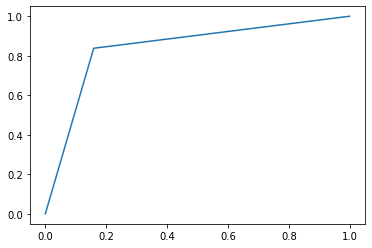

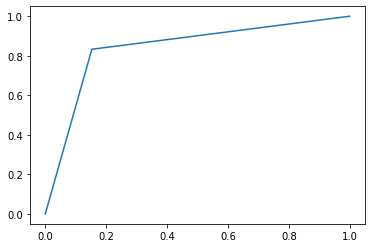

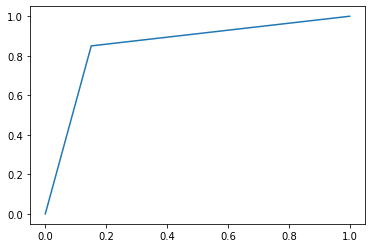

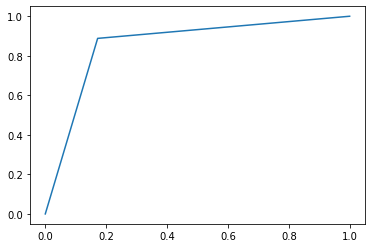

In [59]:
from sklearn.metrics import classification_report
report = classification_report(mnb_bow_predictions,validate_Y)
print(report)
performance(validate_Y,mnb_bow_predictions)

report = classification_report(mnb_tfidf_predictions,validate_Y)
print(report)
performance(validate_Y,mnb_tfidf_predictions)

report = classification_report(svm_bow_predictions,validate_Y)
print(report)
performance(validate_Y,svm_bow_predictions)

report = classification_report(svm_tfidf_predictions,validate_Y)
print(report)
performance(validate_Y,svm_tfidf_predictions)

from sklearn.externals import joblib
joblib.dump(mnb_bow_model, 'mnb_bow.pkl')
joblib.dump(mnb_tfidf_model, 'mnb_tfidf.pkl')
joblib.dump(svm_bow_model, 'svm_bow.pkl')
joblib.dump(svm_tfidf_model, 'svm_tfidf.pkl')

import pickle
tfidf_path = 'tfidf_feature.pkl'
with open(tfidf_path, 'wb') as fw:
    pickle.dump(tfidf_vectorizer, fw)

bow_path = 'bow_feature.pkl'
with open(bow_path, 'wb') as fw:
    pickle.dump(bow_vectorizer, fw)

In [60]:
test_df = pd.read_csv("test.tsv",sep='\t',header=0)
test_review = test_df['review']
# print(test_review[0:10])

0    The fact that I did not like the music is a ve...
1    This is actually a pretty bad film. The ideolo...
2    Thankfully saw this on a plane to Singapore re...
3    I'm watching this on the Sci-Fi channel right ...
4    If you were brought up on a diet of gameshows ...
5    Meryl Streep is such a genius. Well, at least ...
6    The plot of 7EVENTY 5IVE involves college kids...
7    I live in Missouri, so the direct effects of t...
8    Excellent story about teenagers, leaders, high...
9    This is one of those landmark films which need...
Name: review, dtype: object


In [65]:
test_review = clean(test_review)
tfidf_testreview_features = tfidf_vectorizer.transform(test_review)
predictions = svm_tfidf_model.predict(tfidf_testreview_features).tolist()
print(predictions)

[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 

In [73]:
id = test_df['id'].tolist()
dataframe = pd.DataFrame({'id':id,'sentiment':predictions})
dataframe.to_csv('111.tsv',sep='\t')
